In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.init as init
from math import log10
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from PIL import Image, ImageFilter
from os import listdir
from os.path import join

In [2]:
#Data

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y

CROP_SIZE = 128

class DatasetFromFolder(Dataset):
    def __init__(self, image_dir, scale_factor, with_bicubic_upsampling = True):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x) for x in listdir(image_dir) if is_image_file(x)]

        crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
        
        if with_bicubic_upsampling:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.Resize(crop_size, interpolation=Image.BICUBIC),  # bicubic upsampling to get back the original size 
                                        transforms.ToTensor()])
        else:
            self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size), # cropping the image
                                        transforms.Resize(crop_size//scale_factor),  # subsampling the image (half size)
                                        transforms.ToTensor()])
                
        self.target_transform = transforms.Compose([transforms.CenterCrop(crop_size), # since it's the target, we keep its original quality
                                       transforms.ToTensor()])

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        
        # input = input.filter(ImageFilter.GaussianBlur(1)) 
        input = self.input_transform(input)
        target = self.target_transform(target)

        return input, target

    def __len__(self):
        return len(self.image_filenames)

In [3]:
#Model

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [5]:
#Main

# Parameters
BATCH_SIZE = 4
NUM_WORKERS = 0 # on Windows, set this variable to 0
scale_factor = 4
nb_epochs = 15
cuda = True


device = torch.device("cuda:0" if (torch.cuda.is_available() and cuda) else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)


trainset = DatasetFromFolder("data/train", scale_factor=scale_factor)
testset = DatasetFromFolder("data/test", scale_factor=scale_factor)

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(  # we use Adam instead of SGD like in the paper, because it's faster
    [
        {"params": model.conv1.parameters(), "lr": 0.0001},  
        {"params": model.conv2.parameters(), "lr": 0.0001},
        {"params": model.conv3.parameters(), "lr": 0.00001},
    ], lr=0.00001,
)


hist_loss_train = []
hist_loss_test = []
hist_psnr_train = []
hist_psnr_test = []
for epoch in range(nb_epochs):

    # Train
    avg_psnr = 0
    epoch_loss = 0
    for iteration, batch in enumerate(trainloader):
        input, target = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()

        out = model(input)
        loss = criterion(out, target)
        psnr = 10 * log10(1 / loss.item())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        avg_psnr += psnr

    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")
    hist_loss_train.append(epoch_loss / len(trainloader))
    hist_psnr_train.append(avg_psnr / len(trainloader))

    # Test
    avg_psnr = 0
    epoch_loss = 0
    with torch.no_grad():
        for batch in testloader:
            input, target = batch[0].to(device), batch[1].to(device)

            out = model(input)
            loss = criterion(out, target)
            psnr = 10 * log10(1 / loss.item())
            epoch_loss += loss.item()
            avg_psnr += psnr

    print(f"Average PSNR: {avg_psnr / len(testloader)} dB.")
    hist_loss_test.append(epoch_loss / len(testloader))
    hist_psnr_test.append(avg_psnr / len(testloader))

    # Save model
torch.save(model, f"model_{epoch}.pth")

/Users/adriensade/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:23: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.


Epoch 0. Training loss: 0.21128210981213857
Average PSNR: 10.203255421539744 dB.
Epoch 1. Training loss: 0.037821144279506475
Average PSNR: 18.64348355343026 dB.
Epoch 2. Training loss: 0.013336541182878945
Average PSNR: 18.972234388651025 dB.
Epoch 3. Training loss: 0.012473533713510112
Average PSNR: 19.339194104358764 dB.
Epoch 4. Training loss: 0.011539254744078905
Average PSNR: 19.678305446891137 dB.
Epoch 5. Training loss: 0.010605893430433102
Average PSNR: 20.061884038463834 dB.
Epoch 6. Training loss: 0.009536141928817545
Average PSNR: 20.493457967811516 dB.
Epoch 7. Training loss: 0.008784628051909663
Average PSNR: 20.819410509068174 dB.
Epoch 8. Training loss: 0.008191017907053705
Average PSNR: 21.11815089714805 dB.
Epoch 9. Training loss: 0.00769980764755654
Average PSNR: 21.382559419640913 dB.
Epoch 10. Training loss: 0.007309501258922475
Average PSNR: 21.595056631245875 dB.
Epoch 11. Training loss: 0.006979871386041244
Average PSNR: 21.760977239974807 dB.
Epoch 12. Training

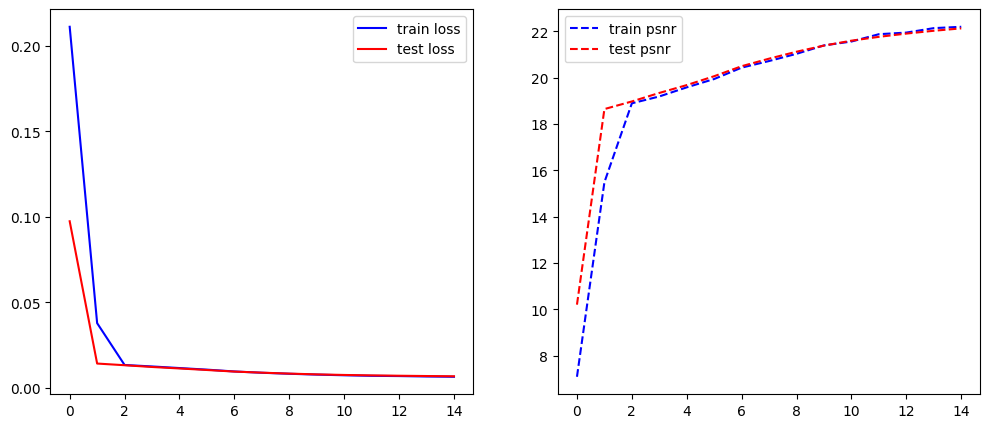

In [6]:
_, ax = plt.subplots(1,2)
ax[0].plot(hist_loss_train, label='train loss', c='b')
ax[0].plot(hist_loss_test, label='test loss', c='r')
ax[0].legend()
ax[1].plot(hist_psnr_train, label='train psnr', c='b', linestyle='--')
ax[1].plot(hist_psnr_test, label='test psnr', c='r', linestyle='--')
ax[1].legend()
_.set_size_inches(12,5)

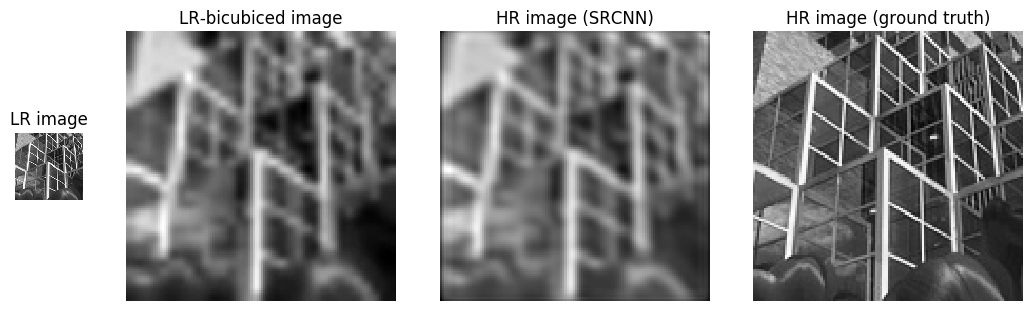

In [14]:
k = np.random.randint(0,13)
for idx, (test_features, test_labels) in enumerate(testloader):
    if idx != k: continue;

    crop_size = CROP_SIZE - (CROP_SIZE % scale_factor) # Valid crop size
    crop = transforms.CenterCrop(crop_size)

    LR_original = crop(test_labels[0]).squeeze()
    LR = test_features[0].squeeze()     #Low Resolution (bicubiced) image
    GT = test_labels[0].squeeze()      #Ground Truth
    HR = (model(test_features.to(device)).cpu().squeeze()[0].detach().numpy()*255.0).clip(0,255)        #High Resolution SRCNN image

    _, ax = plt.subplots(1,4, gridspec_kw={'width_ratios': [1, scale_factor, scale_factor, scale_factor]})
    ax[0].imshow(LR_original, cmap="gray")
    ax[1].imshow(LR, cmap="gray")
    ax[2].imshow(HR, cmap="gray")   
    ax[3].imshow(GT, cmap="gray")
    ax[0].title.set_text('LR image')
    ax[1].title.set_text('LR-bicubiced image')
    ax[2].title.set_text('HR image (SRCNN)')
    ax[3].title.set_text('HR image (ground truth)')

    _.set_size_inches(13,13)
    for i in range(4): ax[i].set_axis_off()
    plt.show()
    #print(f"Label: {label}")